## GitHub & Environment Setup

## Clone & checkout

In [3]:
REPO_URL = "https://github.com/Log-Yair/Endymion.git"
REPO_DIR = "/content/Endymion"
BRANCH = "src"

import os, sys

if not os.path.exists(REPO_DIR):
    !git clone {REPO_URL} {REPO_DIR}

%cd {REPO_DIR}
!git checkout {BRANCH}
!git pull


/content/Endymion
Already on 'src'
Your branch is up to date with 'origin/src'.
Already up to date.


### Verify repo state

In [4]:
!pwd
!git branch --show-current
!git log -1 --oneline
!ls


/content/Endymion
src
931d57d (HEAD -> src, origin/src) Enhance hazard assessment handling in Evaluator for backward compatibility with older notebook schema
benchmark_runner.py  data_handler.py  feature_extractor.py  pathfinder.py
crater_predictor.py  evaluator.py     hazard_assessor.py    README.md


### Make imports work

In [5]:
import sys
if REPO_DIR not in sys.path:
    sys.path.append(REPO_DIR)

print("sys.path OK:", REPO_DIR in sys.path)


sys.path OK: True


### verify content

In [6]:
# References / notes:
# - Ensures Python can import modules from the repo's src/ folder (data_handler.py, etc.)
# - This replaces the placeholder path that can break imports in Colab.

import sys
SRC_DIR = "/content/Endymion/src"
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

print("sys.path contains SRC_DIR:", SRC_DIR in sys.path)


sys.path contains SRC_DIR: True


## update colab

In [7]:
%cd /content/Endymion
!git branch --show-current   # should say: src
!git pull


/content/Endymion
src
Already up to date.


## Run Pipeline (prototype)

Imports

In [8]:
# References / notes:
# - Imports match your Phase-1 module layout in src/
#   data_handler.py, feature_extractor.py, hazard_assessor.py, pathfinder.py, evaluator.py

import numpy as np
from data_handler import DataHandler, LOLATileSpec, CANONICAL_ROI
from feature_extractor import FeatureExtractor
from hazard_assessor import HazardAssessor
from pathfinder import Pathfinder, build_cost_from_hazard, make_corridor_mask
from evaluator import Evaluator


## Configuration

In [9]:
from google.colab import drive
drive.mount('/content/drive')

PERSIST = "/content/drive/MyDrive/endymion_cache/lola"
RUNTIME = "/content/endymion_runtime_cache/lola"

Mounted at /content/drive


## Run per session

In [10]:
BASE = "https://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/lola_gdr/polar/float_img"

tiles = [
    LOLATileSpec(
        tile_id="ldem_85s_20m",
        img_filename="ldem_85s_20m_float.img",
        lbl_filename="ldem_85s_20m_float.lbl",
    )
]


## initialise Dh

In [11]:
dh = DataHandler(
    base_url=BASE,
    tiles=tiles,
    persistent_dir=PERSIST,
    runtime_dir=RUNTIME,
    allow_download=True,
    force_download=False,
)

##Load or compute DEM patch

In [12]:
patch = dh.get_patch("ldem_85s_20m", CANONICAL_ROI, verbose=True)
dem_m = patch.data

print("Patch meta:", patch.meta.extra)

Patch meta: {'nan_ratio': 0.0, 'min_m': -2872.5341796875, 'max_m': 1738.65771484375, 'lbl_unit': 'KILOMETER', 'lbl_scaling_factor': 1.0, 'lbl_offset': 1737.4, 'tile_shape': (15168, 15168)}


## Feature extraction

In [13]:
fx = FeatureExtractor(pixel_size_m=20.0, slope_units="degrees")
features = fx.extract(dem_m)
print({k: v.shape for k, v in features.items()})

{'slope_deg': (1024, 1024), 'slope_rise_run': (1024, 1024), 'roughness_rms': (1024, 1024)}


## save dem

In [14]:
out_dir = dh.save_derived(
    tile_id="ldem_85s_20m",
    roi=CANONICAL_ROI,
    dem_m=dem_m,
    features=features,
    meta_extra={"note": "regenerated slope + roughness"},
)

print("Saved derived products to:", out_dir)

Saved derived products to: /content/drive/MyDrive/endymion_cache/lola/derived/ldem_85s_20m/roi_7072_8096_7072_8096


## Fast reload test

In [15]:
cached = dh.load_derived("ldem_85s_20m", CANONICAL_ROI)
slope = cached["slope_deg"]
rough = cached["roughness_rms"]
print("Loaded keys:", cached.keys())
print("DEM shape:", cached["dem_m"].shape)

Loaded keys: dict_keys(['meta', 'dem_m', 'slope_deg', 'roughness_rms'])
DEM shape: (1024, 1024)


## Hazard asessor


In [16]:

ha = HazardAssessor(
    slope_deg_max=30.0,
    roughness_rms_max=1.0,
    w_slope=0.7,
    w_roughness=0.3,
)

result = ha.assess(
    slope_deg=slope,
    roughness_rms=rough,
    dem_m=dem_m,   # optional, unused for now
)

hazard = result["hazard"]

print("Hazard stats:", result["meta"]["stats"])

Hazard stats: {'hazard_min': 0.08308399468660355, 'hazard_max': 1.0, 'hazard_mean': 0.6926180720329285, 'nan_ratio': 0.0}


after loading slope

In [17]:
print("Slope min/max (deg):",
      float(np.nanmin(slope)),
      float(np.nanmax(slope)))

Slope min/max (deg): 0.006155341397970915 66.46864318847656


the hazard mean tells me that its saturating quite the amount of data of the map, which, rigth now, its not "bad", but not ideal, as it reduces the contrast for pathfinding and later additions

In [18]:

# slope is cached["slope_deg"]
slope_valid = slope[~np.isnan(slope)]

percentiles = np.percentile(
    slope_valid,
    [50, 75, 90, 95, 99]
)

print("Slope percentiles (degrees):")
for p, v in zip([50, 75, 90, 95, 99], percentiles):
    print(f"P{p}: {v:.2f}°")

rough_valid = rough[~np.isnan(rough)]

print("Roughness percentiles (m):")
for p, v in zip([50, 75, 90, 95, 99],
                np.percentile(rough_valid, [50, 75, 90, 95, 99])):
    print(f"P{p}: {v:.3f} m")

Slope percentiles (degrees):
P50: 15.27°
P75: 25.25°
P90: 32.20°
P95: 34.55°
P99: 38.37°
Roughness percentiles (m):
P50: 7.676 m
P75: 13.678 m
P90: 17.637 m
P95: 18.560 m
P99: 19.956 m


re assess considering P95 as vmax to avoid outliers and set hazard map to 1.0

In [19]:
import numpy as np

mask_ratio = float((slope > 40.0).mean())
print("Masked pixels (slope > 40°) ratio:", mask_ratio)

print("Hazard P50/P90/P95/P99:",
      np.percentile(hazard, [50, 90, 95, 99]))

Masked pixels (slope > 40°) ratio: 0.00437164306640625
Hazard P50/P90/P95/P99: [0.65625992 1.         1.         1.        ]


In [20]:

slope_p95 = float(np.percentile(slope, 95))
rough_p95 = float(np.percentile(rough, 95))

ha = HazardAssessor(
slope_deg_max=slope_p95,
roughness_rms_max=rough_p95,
use_impassable_mask=True,
impassable_slope_deg=40.0
)

result = ha.assess(
    slope_deg=slope,
    roughness_rms=rough,
    dem_m=dem_m,   # optional, unused for now
)
hazard = result["hazard"]

print("Hazard stats:", result["meta"]["stats"])

Hazard stats: {'hazard_min': 0.005693952552974224, 'hazard_max': 1.0, 'hazard_mean': 0.4982340633869171, 'nan_ratio': 0.0}


after evaluating the hazardous stats, i realised that there's at least a ~10% of the grid is saturated at a hazard=1.0.
This does not mean that is broken, but it does reduce contrast for pathfinding since there are lots of equal maxed graded areas.

So, after considering thi, i believe that a change in the normalisation on the ceilings may be suitable for the current prototype. Going from using P95, which means that everything above P95 gets clippled to 1.0, to P99 so its easy for the weigthed sum to hit 1.0 acorss bigger chuncks  

In [21]:

ha = HazardAssessor(
slope_deg_max=38.37, # P99
roughness_rms_max=19.956, # P99
use_impassable_mask=True,
impassable_slope_deg=40.0, # keep mask cut off
)

result = ha.assess(
    slope_deg=slope,
    roughness_rms=rough,
    dem_m=dem_m,   # optional, unused for now
)
hazard = result["hazard"]

print("Hazard stats:", result["meta"]["stats"])

Hazard stats: {'hazard_min': 0.0052759707905352116, 'hazard_max': 1.0, 'hazard_mean': 0.4554160237312317, 'nan_ratio': 0.0}


In [22]:
import numpy as np

print("Hazard stats:", result["meta"]["stats"])
print("Hazard P50/P90/P95/P99:", np.percentile(hazard, [50, 90, 95, 99]))
print("Masked ratio:", float((slope > 40.0).mean()))

Hazard stats: {'hazard_min': 0.0052759707905352116, 'hazard_max': 1.0, 'hazard_mean': 0.4554160237312317, 'nan_ratio': 0.0}
Hazard P50/P90/P95/P99: [0.3939901  0.85053384 0.90437332 0.98357247]
Masked ratio: 0.00437164306640625


##Pathfinding

###Run a path

In [43]:
from pathfinder import Pathfinder
import numpy as np

# Example start/goal (row, col based)
start = (100, 50)
goal  = (500, 730)

alpha = 10.0
cost = (1.0 + alpha * hazard).astype(np.float32)
cost[hazard >= 1.0] = 1e6  # treat impassable as blocked-ish

pf = Pathfinder(connectivity=8, block_cost=1e6)
res = pf.find_path(cost, start, goal)

print("Success:", res["success"])
print("Total cost:", res["total_cost"])
print("Path length:", len(res["path_rc"]))
print("Meta:", res["meta"])

Success: True
Total cost: 3740.514404296875
Path length: 718
Meta: {'expansions': 684843, 'connectivity': 8, 'heuristic_weight': 1.2}


quick metric evaluation

In [44]:
path = res["path_rc"]
if res["success"] and path:
    path_haz = np.array([hazard[r, c] for r, c in path], dtype=np.float32)
    print("Path hazard mean:", float(path_haz.mean()))
    print("Path hazard max:", float(path_haz.max()))

Path hazard mean: 0.2964661419391632
Path hazard max: 0.9911328554153442


### visualisation of the path

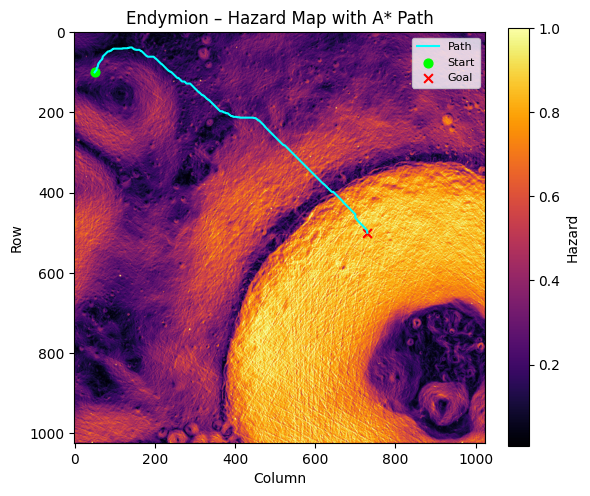

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# already have:
# hazard : (H, W) float32
# res["path_rc"] : list[(r,c)]
# start, goal : (r,c)

fig, ax = plt.subplots(figsize=(6, 6))

# Show hazard map
im = ax.imshow(
    hazard,
    cmap="inferno",
    origin="upper"
)

# Plot path if it exists
if res["success"] and res["path_rc"]:
    path = np.array(res["path_rc"])
    ax.plot(
        path[:, 1], path[:, 0],
        color="cyan",
        linewidth=1.5,
        label="Path"
    )

# Start / goal markers
ax.scatter(start[1], start[0], c="lime", s=40, marker="o", label="Start")
ax.scatter(goal[1], goal[0], c="red",  s=40, marker="x", label="Goal")

ax.set_title("Endymion – Hazard Map with A* Path")
ax.set_xlabel("Column")
ax.set_ylabel("Row")
ax.legend(loc="upper right", fontsize=8)

plt.colorbar(im, ax=ax, fraction=0.046, label="Hazard")
plt.tight_layout()
plt.show()

extra metrics

In [26]:
import numpy as np

path = np.array(res["path_rc"], dtype=np.int32)
path_cost = np.array([cost[r, c] for r, c in path], dtype=np.float32)

print("Path cost mean:", float(path_cost.mean()))
print("Path cost max:", float(path_cost.max()))
print("Total cost (recomputed):", float(path_cost.sum()))

Path cost mean: 2.4286909103393555
Path cost max: 5.1471991539001465
Total cost (recomputed): 1918.665771484375


comnsidering that the path cost = ~4.15; path max = ~ 10.88; and the total cost = 4673
i believe that by smothing some of the pixels, it may help reduce noise and by consequence, help the A* algorithm reduce the total expansions nedeed to perform the pathfinding

In [27]:

def smooth3x3_mean(arr: np.ndarray) -> np.ndarray:
    """
    Simple 3x3 mean smoothing using padding + slicing.
    Keeps output same shape. NaNs not expected in your hazard, but handled.
    """
    a = arr.astype(np.float32, copy=False)
    p = np.pad(a, 1, mode="edge")

    # 3x3 sum via 9 shifted views
    s = (
        p[0:-2, 0:-2] + p[0:-2, 1:-1] + p[0:-2, 2:] +
        p[1:-1, 0:-2] + p[1:-1, 1:-1] + p[1:-1, 2:] +
        p[2:,   0:-2] + p[2:,   1:-1] + p[2:,   2:]
    ) / 9.0

    return s.astype(np.float32)

hazard_s = smooth3x3_mean(hazard)

alpha = 10.0
cost_s = (1.0 + alpha * hazard_s).astype(np.float32)
cost_s[hazard >= 1.0] = 1e6  # keep your original hard mask behaviour

res_s = pf.find_path(cost_s, start, goal)

print("Smoothed success:", res_s["success"])
print("Smoothed expansions:", res_s["meta"].get("expansions"))
print("Smoothed path length:", len(res_s["path_rc"]))

Smoothed success: True
Smoothed expansions: 241508
Smoothed path length: 790


considering the smothing performed and its results:
 - smothing did almost nothing.
 - the improvement perventage is minute as of now
 - expansions and path length are basically the same
 - it does not help the scalability of the project as A* stil tries to read the entire map

this means that the main issue is not small pixel noise; it’s that A* still has no strong guidance to avoid exploring everything

in order keep the project "safe" and "fast", i will the following decision:

A) Safety constraint (hard rules)

These should never be violated.
Examples (prototype versions):

slope > 40° → blocked

hazard > 0.95 → blocked (optional)

(to be implemented) permanent shadow / illumination risk → blocked

(to be implemented) high crater probability → blocked

B) Optimisation (find best path through the remaining safe space)

This is where A* / Dijkstra operates.

This separation will keep/help the “rover/astronaut safetiness” without pretending the model is perfect

therefore I think that introducing a second safety mask(hazard ceiling) its the most appropiate approach to the situation

Right now, hazard close to 1.0 is still allowed (unless slope triggers the mask). That’s why path hazard max ~0.99 reapears.

For a “safety-first” prototype, it’s reasonable to say:

“Cells above a hazard threshold are treated as non-traversable until more data/models exist.”

In [28]:
from pathfinder import Pathfinder, build_cost_from_hazard
import numpy as np


# 1) Inputs (already computed)
# hazard : np.ndarray (H, W), float32 in [0,1]
# slope  : np.ndarray (for diagnostics only)
# dem_m  : np.ndarray (unused here)

start = (100, 50)
goal  = (950, 350)

# 2) Safety & cost parameters
alpha = 10.0                 # hazard importance vs distance
hazard_block = 0.95          # SECOND safety mask
block_cost = 1e6

# 3) Build traversal cost grid
cost = build_cost_from_hazard(
    hazard=hazard,
    alpha=alpha,
    hazard_block=hazard_block,
    block_cost=block_cost,
)

# 4) Pathfinder configuration
pf = Pathfinder(
    connectivity=8,
    block_cost=block_cost,
    heuristic_weight=2.0,     # Weighted A* (speed-up)
)

# 5) Run pathfinding
res = pf.find_path(cost, start, goal)

# 6) Basic reporting
print("Success:", res["success"])
print("Total cost:", res["total_cost"])
print("Path length:", len(res["path_rc"]))
print("Meta:", res["meta"])

# 7) Safety diagnostics
if res["success"] and res["path_rc"]:
    path = res["path_rc"]
    path_haz = [hazard[r, c] for r, c in path]
    print("Path hazard mean:", float(sum(path_haz) / len(path_haz)))
    print("Path hazard max :", float(max(path_haz)))

Success: True
Total cost: 3379.71337890625
Path length: 912
Meta: {'expansions': 446451, 'connectivity': 8, 'heuristic_weight': 2.0}
Path hazard mean: 0.23036633431911469
Path hazard max : 0.5969157218933105


results appear to be slightly "better", but lets see what i can get by tweaking the heuristic a little
below are the results given a start poit (50,50); end goal(950,950)

v1.5

Success: True

Total cost: 6329.42919921875

Path length: 1128

Meta: {'expansions': 991152, 'connectivity': 8, 'heuristic_weight': 1.2}

Path hazard mean: 0.32317855954170227

Path hazard max : 0.9454504251480103


v1.6

Success: True

Total cost: 6330.82080078125

Path length: 1129

Meta: {'expansions': 979278, 'connectivity': 8, 'heuristic_weight': 1.5}

Path hazard mean: 0.32294324040412903

Path hazard max : 0.9454504251480103

v.1.7

Success: True

Total cost: 6329.34521484375

Path length: 1129

Meta: {'expansions': 994294, 'connectivity': 8, 'heuristic_weight': 1.1}

Path hazard mean: 0.3228815495967865

Path hazard max : 0.9454504251480103

v1.8
Success: True

Total cost: 6364.59033203125

Path length: 1139

Meta: {'expansions': 959354, 'connectivity': 8, 'heuristic_weight': 2.0}

Path hazard mean: 0.322325199842453

Path hazard max : 0.9491086006164551

after considering the second mask, a stricter safety meter, as well as done a few testing to the see if the overall performance could be improved, i decided to use the following

Use hazard_block = 0.95

Reason: it keeps routes feasible while still avoiding extreme hazard. It’s a good “prototype conservative” threshold.

Use heuristic_weight = 2.0

Reason: it gives you the best speed you’ve measured so far without meaningfully hurting safety:

-expansions lowest (~959k)

-path hazard mean basically unchanged

-hazard max still under 0.95

I also take in consideration the use 0.90 as a “high-safety mode”:

-For astronaut/lander “extra conservative”

-For demonstrations of safety-first planning

But, i must say that:

-It increases cost and length (detours)

-It may fail in other ROIs if too much terrain gets blocked

so it can only be use when the conditions are met

In short the algorithm is now forced to avoid the most dangerous terrain, even if that makes the route slightly less optimal.

based on the performance achieved, and considering that the idea of the prototype is to make it as scalable as possible, i believe that replacing the smothing with a corridor which, in short, it will help restrict the search space needed as it cuts by order of magnitud, basically only allowing A* to search within the tube, nad if nothing is found, then "widen" the tube and retry

In [29]:
# References / notes:
# - Uses your updated Pathfinder corridor approach (make_corridor_mask + weighted A*)
# - Adds a NaN-safety fill BEFORE build_cost_from_hazard (treat unknown hazard as unsafe)
# - Captures 'best_radius_px' + a corridor experiment log for nav_meta.json

import numpy as np
from pathfinder import Pathfinder, build_cost_from_hazard, make_corridor_mask

# -------------------------
# 0) Inputs expected to exist from earlier cells
# -------------------------
# hazard : np.ndarray (H,W) float32 in [0,1] (may contain NaNs)
# dem_m  : np.ndarray (H,W) metres (optional for this cell)
# start, goal : (r,c) tuples in ROI-local coords (0..1023)

def fill_hazard_nans(h: np.ndarray, fill: float = 1.0) -> np.ndarray:
    """Safety-first: NaN hazard is treated as very dangerous (fill=1.0)."""
    if not np.isnan(h).any():
        return h.astype(np.float32, copy=False)
    out = h.astype(np.float32, copy=True)
    out[np.isnan(out)] = float(fill)
    return out

hazard_safe = fill_hazard_nans(hazard, fill=1.0)

# -------------------------
# 1) Build cost (hazard -> traversal cost)
# -------------------------
alpha = 10.0
hazard_block = 0.95
block_cost = 1e6

cost = build_cost_from_hazard(
    hazard=hazard_safe,
    alpha=alpha,
    hazard_block=hazard_block,
    block_cost=block_cost,
)

# -------------------------
# 2) Pathfinder (weighted A*)
# -------------------------
pf = Pathfinder(
    connectivity=8,
    block_cost=block_cost,
    heuristic_weight=2.0,   # your best-performing "fast mode"
)

# -------------------------
# 3) Corridor sweep
# -------------------------
corridor_radii = [25, 50, 80, 120, 180, 260, 400]

best = None
best_radius_px = None
corridor_experiment = []

for rad in corridor_radii:
    allowed = make_corridor_mask(cost.shape, start, goal, radius_px=rad)
    res = pf.find_path(cost, start, goal, allowed_mask=allowed)

    row = {
        "radius_px": int(rad),
        "success": bool(res["success"]),
        "path_len": int(len(res["path_rc"])),
        "expansions": int(res["meta"].get("expansions", -1)),
        "total_cost": float(res["total_cost"]) if res["success"] else None,
    }
    corridor_experiment.append(row)

    print(f"[corridor {rad:>3}px] success={row['success']} expansions={row['expansions']} path_len={row['path_len']}")

    if res["success"] and res["path_rc"]:
        best = res
        best_radius_px = int(rad)
        break

if best is None:
    print("No path found even after widening corridor.")
else:
    path = best["path_rc"]
    path_haz = np.array([hazard_safe[r, c] for r, c in path], dtype=np.float32)

    print("\nFINAL PATH")
    print("Success:", best["success"])
    print("Total cost:", best["total_cost"])
    print("Path length:", len(path))
    print("Meta:", best["meta"])
    print("Path hazard mean:", float(path_haz.mean()))
    print("Path hazard max :", float(path_haz.max()))

# Export variables for later cells
hazard = hazard_safe  # overwrite with safe version used by cost


[corridor  25px] success=True expansions=46022 path_len=867

FINAL PATH
Success: True
Total cost: 3772.750732421875
Path length: 867
Meta: {'expansions': 46022, 'connectivity': 8, 'heuristic_weight': 2.0}
Path hazard mean: 0.28429314494132996
Path hazard max : 0.5871003270149231


based on the results obtained:
corridor is too tight up to 260 px, so the only viable route must “detour” outside that tube.

At 400 px the corridor finally includes a feasible path.

A narrow corridor forces the search to stay close to the straight-line route.

In this ROI, the straight-line vicinity contains hazard-blocked cells (hazard ≥ 0.95), so no valid path exists within smaller corridors.

At radius=400 px, the corridor finally includes a feasible detour around the blocked region, enabling path discovery.

To close this, lets capturs the corridor by printing each radius result
It Saves:
hazard.npy

cost.npy

path_rc.npy

nav_meta.json containing thresholds/weights/radius/expansions/etc.

It uses the existing DataHandler derived cache path:
dh.derived_dir(tile_id, roi)

In [30]:
import numpy as np

tile_id = tiles[0].tile_id

# Path output (ROI-local rc pairs)
if best is not None and best.get("success") and best.get("path_rc"):
    path_rc = np.asarray(best["path_rc"], dtype=np.int32)
    success = True
else:
    path_rc = np.zeros((0, 2), dtype=np.int32)
    success = False

# --- hazard_mean for evaluator compatibility ---
hz_f = hazard[np.isfinite(hazard)]
hazard_mean_global = float(np.mean(hz_f)) if hz_f.size else 1.0

# Build nav_meta in the schema as Evaluator expects
nav_meta = {
    "tile_id": tile_id,
    "roi": list(CANONICAL_ROI),
    "start_rc": list(start),
    "goal_rc": list(goal),

    # IMPORTANT: evaluator expects this key path
    "hazard_assessor": {
        "type": "prototype",
        "stats": {
            "hazard_mean": hazard_mean_global,
        },
    },

    "cost_model": {
        "alpha": float(alpha),
        "hazard_block": float(hazard_block),
        "block_cost": float(block_cost),
    },

    "pathfinder": {
        "connectivity": int(pf.connectivity),
        "heuristic_weight": float(pf.heuristic_weight),
        "best_corridor_radius_px": int(best_radius_px) if best_radius_px is not None else None,
        "corridor_radii": list(map(int, corridor_radii)),
    },

    "result": {
        "success": bool(success),
        "total_cost": float(best["total_cost"]) if success else None,
        "path_len": int(path_rc.shape[0]),
        "expansions": int(best["meta"].get("expansions", -1)) if best is not None else -1,
        "failure_reason": None if success else "no_path_found_in_any_corridor",
    },

    "corridor_experiment": corridor_experiment,
}

# Save
out_dir = dh.save_navigation(
    tile_id=tile_id,
    roi=CANONICAL_ROI,
    hazard=hazard,
    cost=cost,
    path_rc=path_rc,
    nav_meta=nav_meta,
    run_name="navigation_v1",
    save_json_path=True,
)

print("Saved navigation run to:", out_dir)


Saved navigation run to: /content/drive/MyDrive/endymion_cache/lola/derived/ldem_85s_20m/roi_7072_8096_7072_8096/navigation_v1


### Visualisation of the path using the Corridor Pathfinder results

the code below has been suggested by Gemini in order to provide a better visualasation of the corridor result

DEM shape: (1024, 1024) min/max: -2872.5341796875 1738.65771484375
Hazard shape: (1024, 1024) min/max: 0.0052759707905352116 1.0
Cost shape: (1024, 1024) min/max: 1.0527596473693848 1000000.0
Path nodes: 867


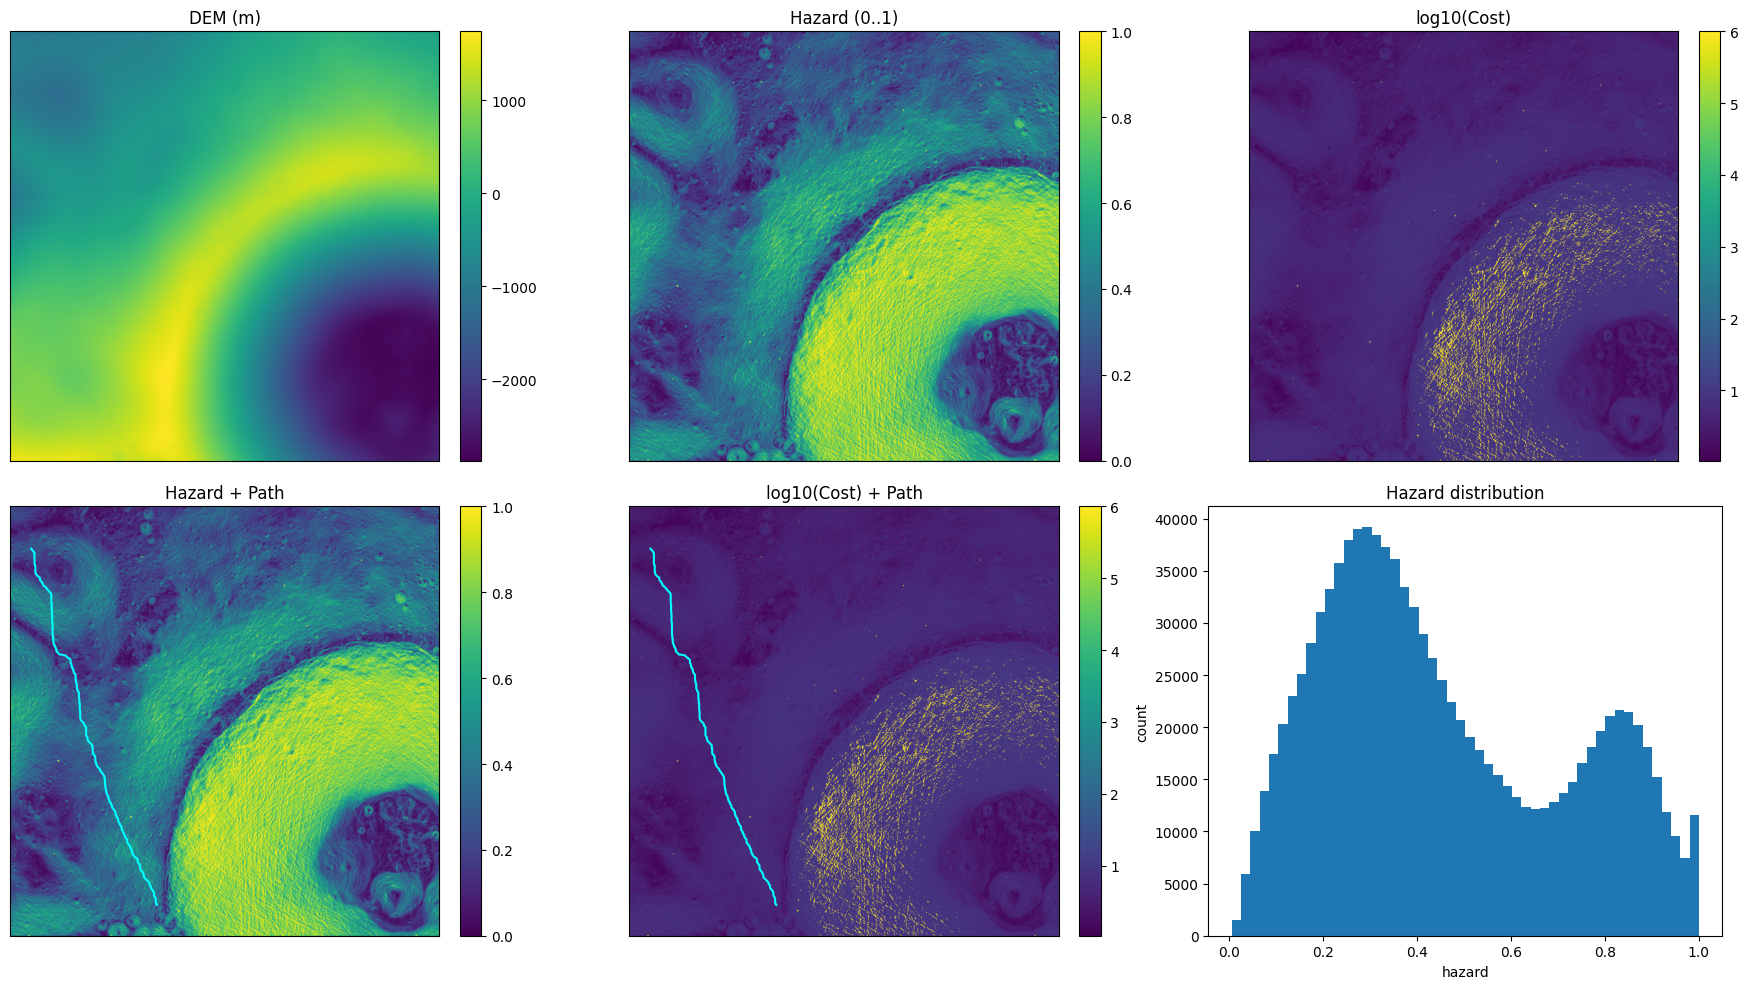

Path hazard mean: 0.28429314494132996
Path hazard max : 0.5871003270149231


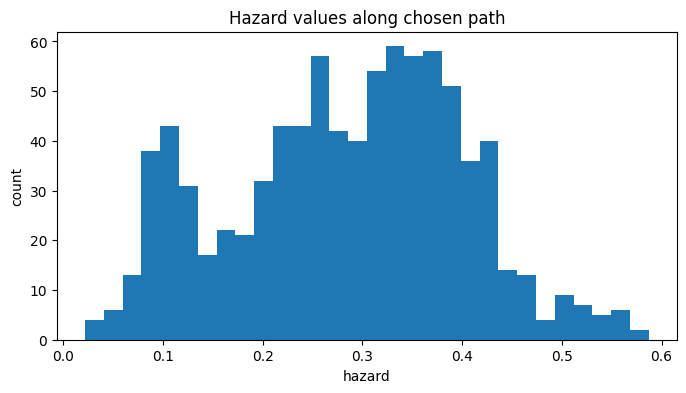

In [31]:
# References / notes:
# - Matplotlib visualisation for Endymion prototype outputs
# - Shows DEM/hazard/cost and overlays the chosen path if available

import numpy as np
import matplotlib.pyplot as plt

def plot_raster(ax, img, title, vmin=None, vmax=None):
    im = ax.imshow(img, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

def overlay_path(ax, path_rc, color="cyan", lw=1.5):
    if path_rc is None or len(path_rc) == 0:
        return
    rr = path_rc[:, 0]
    cc = path_rc[:, 1]
    ax.plot(cc, rr, linewidth=lw, color=color)

# Ensure it have a path_rc variable (from    save cell)
# If not, infer from best["path_rc"].
try:
    _path_rc = path_rc
except NameError:
    if best is not None and best.get("success") and best.get("path_rc"):
        _path_rc = np.asarray(best["path_rc"], dtype=np.int32)
    else:
        _path_rc = np.zeros((0,2), dtype=np.int32)

# Basic sanity stats
print("DEM shape:", dem_m.shape, "min/max:", float(np.nanmin(dem_m)), float(np.nanmax(dem_m)))
print("Hazard shape:", hazard.shape, "min/max:", float(np.nanmin(hazard)), float(np.nanmax(hazard)))
print("Cost shape:", cost.shape, "min/max:", float(np.nanmin(cost)), float(np.nanmax(cost)))
print("Path nodes:", int(_path_rc.shape[0]))

# Make cost viewable (log compress)
cost_view = np.log10(np.clip(cost, 1.0, np.nanmax(cost)))

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

plot_raster(axs[0,0], dem_m, "DEM (m)")
plot_raster(axs[0,1], hazard, "Hazard (0..1)", vmin=0.0, vmax=1.0)
plot_raster(axs[0,2], cost_view, "log10(Cost)")

# Hazard + path
axs[1,0].imshow(hazard, vmin=0.0, vmax=1.0)
axs[1,0].set_title("Hazard + Path")
axs[1,0].set_xticks([]); axs[1,0].set_yticks([])
overlay_path(axs[1,0], _path_rc)
plt.colorbar(axs[1,0].images[0], ax=axs[1,0], fraction=0.046, pad=0.04)

# Cost + path
axs[1,1].imshow(cost_view)
axs[1,1].set_title("log10(Cost) + Path")
axs[1,1].set_xticks([]); axs[1,1].set_yticks([])
overlay_path(axs[1,1], _path_rc)
plt.colorbar(axs[1,1].images[0], ax=axs[1,1], fraction=0.046, pad=0.04)

# Hazard distribution
hf = hazard[np.isfinite(hazard)]
axs[1,2].hist(hf, bins=50)
axs[1,2].set_title("Hazard distribution")
axs[1,2].set_xlabel("hazard"); axs[1,2].set_ylabel("count")

plt.tight_layout()
plt.show()

# Path hazard stats
if _path_rc.shape[0] > 0:
    path_h = np.array([hazard[r, c] for r, c in _path_rc], dtype=np.float32)
    print("Path hazard mean:", float(np.mean(path_h)))
    print("Path hazard max :", float(np.max(path_h)))

    plt.figure(figsize=(8,4))
    plt.hist(path_h, bins=30)
    plt.title("Hazard values along chosen path")
    plt.xlabel("hazard"); plt.ylabel("count")
    plt.show()
else:
    print("No path to analyse.")


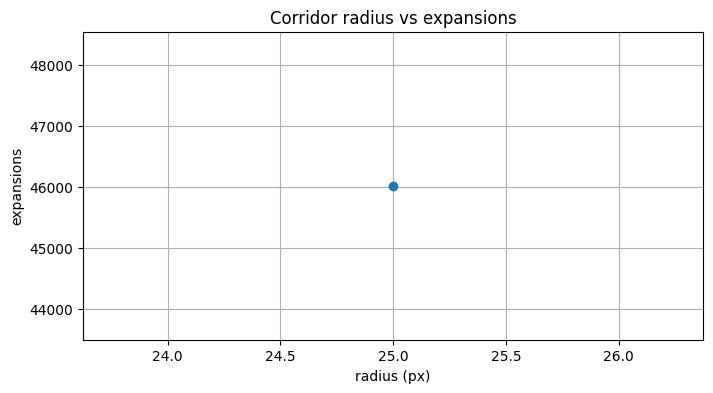

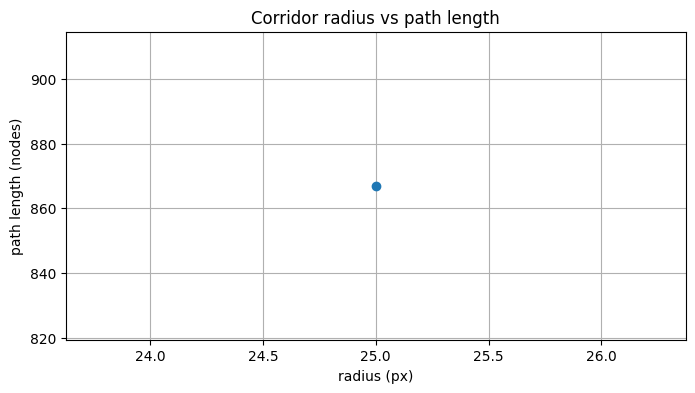

First successful radius: 25


In [32]:
import numpy as np
import matplotlib.pyplot as plt

if "corridor_experiment" in globals() and len(corridor_experiment) > 0:
    radii = np.array([r["radius_px"] for r in corridor_experiment], dtype=np.int32)
    expansions = np.array([r["expansions"] for r in corridor_experiment], dtype=np.int32)
    path_lens = np.array([r["path_len"] for r in corridor_experiment], dtype=np.int32)
    success = np.array([r["success"] for r in corridor_experiment], dtype=bool)

    plt.figure(figsize=(8,4))
    plt.plot(radii, expansions, marker="o")
    plt.title("Corridor radius vs expansions")
    plt.xlabel("radius (px)")
    plt.ylabel("expansions")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(radii, path_lens, marker="o")
    plt.title("Corridor radius vs path length")
    plt.xlabel("radius (px)")
    plt.ylabel("path length (nodes)")
    plt.grid(True)
    plt.show()

    print("First successful radius:", int(radii[success][0]) if success.any() else None)
else:
    print("corridor_experiment not found / empty.")


Auto export the figures

In [33]:
from pathlib import Path

SAVE_FIGS = True

def save_figure(fig, name, out_dir):
    if not SAVE_FIGS:
        return
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    path = out_dir / f"{name}.png"
    fig.savefig(path, dpi=200, bbox_inches="tight")
    print(f"Saved figure: {path}")


save

In [34]:
fig = plt.gcf()
save_figure(fig, "hazard_cost_path_overview", out_dir)


Saved figure: /content/drive/MyDrive/endymion_cache/lola/derived/ldem_85s_20m/roi_7072_8096_7072_8096/navigation_v1/hazard_cost_path_overview.png


<Figure size 640x480 with 0 Axes>

the demo below was crafted with the help of ChatGpt in order to faciliatte a demonstration

note: it is quite messy up there 🤦

## DEMO

In [35]:
# Demo navigation scenarios (ROI-local coordinates)

DEMO_SCENARIOS = {
    "easy": {
        "start": (100, 100),
        "goal": (900, 200),
    },
    "medium": {
        "start": (120, 900),
        "goal": (850, 150),
    },
    "hard": {
        "start": (50, 500),
        "goal": (950, 600),
    },
}

SCENARIO_NAME = "easy"  # "easy" | "medium" | "hard"

start = DEMO_SCENARIOS[SCENARIO_NAME]["start"]
goal  = DEMO_SCENARIOS[SCENARIO_NAME]["goal"]

print(f"Running demo scenario: {SCENARIO_NAME}")
print("Start:", start)
print("Goal :", goal)


Running demo scenario: easy
Start: (100, 100)
Goal : (900, 200)


### Run path

In [36]:
# References / notes:
# - Runs corridor-based navigation for the selected demo scenario
# - Produces: path_rc, best, best_radius_px, corridor_experiment
# - Prints a clean path-quality summary for narration

import time
import numpy as np
from pathfinder import Pathfinder, build_cost_from_hazard, make_corridor_mask

PIXEL_SIZE_M = 20.0

# Prototype parameters
alpha = 10.0
hazard_block = 0.95
block_cost = 1e6
corridor_radii = [25, 50, 80, 120, 180, 260, 400]

CONNECTIVITY = 8
HEURISTIC_WEIGHT = 2.0

def fill_hazard_nans(h: np.ndarray, fill: float = 1.0) -> np.ndarray:
    """Safety-first: NaN hazard treated as dangerous."""
    if not np.isnan(h).any():
        return h.astype(np.float32, copy=False)
    out = h.astype(np.float32, copy=True)
    out[np.isnan(out)] = float(fill)
    return out

# --- Prepare hazard + cost ---
hazard_safe = fill_hazard_nans(hazard, fill=1.0)

cost = build_cost_from_hazard(
    hazard=hazard_safe,
    alpha=alpha,
    hazard_block=hazard_block,
    block_cost=block_cost,
)

cost_view = np.log10(np.clip(cost, 1.0, np.nanmax(cost)))

# --- Pathfinder ---
pf = Pathfinder(
    connectivity=CONNECTIVITY,
    block_cost=block_cost,
    heuristic_weight=HEURISTIC_WEIGHT,
)

best = None
best_radius_px = None
corridor_experiment = []

t0 = time.perf_counter()

for rad in corridor_radii:
    allowed = make_corridor_mask(cost.shape, start, goal, radius_px=int(rad))
    res = pf.find_path(cost, start, goal, allowed_mask=allowed)

    corridor_experiment.append({
        "radius_px": int(rad),
        "success": bool(res["success"]),
        "path_len": int(len(res["path_rc"])),
        "expansions": int(res["meta"].get("expansions", -1)),
        "total_cost": float(res["total_cost"]) if res["success"] else None,
    })

    print(f"[corridor {rad:>3}px] success={res['success']} expansions={res['meta'].get('expansions', -1)}")

    if res["success"] and res["path_rc"] and best is None:
        best = res
        best_radius_px = int(rad)

elapsed_s = time.perf_counter() - t0

# --- Path quality summary ---
if best is not None and best.get("success") and best.get("path_rc"):
    path_rc = np.asarray(best["path_rc"], dtype=np.int32)
    path_h = np.array([hazard_safe[r, c] for r, c in path_rc], dtype=np.float32)

    path_len_m = float(len(path_rc) * PIXEL_SIZE_M)
    mean_h = float(np.mean(path_h))
    max_h  = float(np.max(path_h))
    frac_above = float(np.mean(path_h >= hazard_block))

    print("\n--- Path Quality Summary ---")
    print(f"Scenario            : {SCENARIO_NAME}")
    print(f"Best corridor (px)  : {best_radius_px}")
    print(f"Runtime (s)         : {elapsed_s:.3f}")
    print(f"Path length (nodes) : {len(path_rc)}")
    print(f"Path length (m)     : {path_len_m:.1f}")
    print(f"Total cost          : {best['total_cost']:.2f}")
    print(f"Mean hazard (path)  : {mean_h:.3f}")
    print(f"Max hazard (path)   : {max_h:.3f}")
    print(f"% ≥ threshold      : {100*frac_above:.2f}%")
    print(f"Expansions          : {best['meta'].get('expansions', -1)}")

else:
    path_rc = np.zeros((0, 2), dtype=np.int32)
    print("\nNo valid path found.")
    print(f"Runtime (s): {elapsed_s:.3f}")


[corridor  25px] success=True expansions=40576
[corridor  50px] success=True expansions=78965


KeyboardInterrupt: 

### visualisation of the demo

In [ ]:
# References / notes:
# - Demo visualisation for prototype:
#   1) Hazard + corridor + path + start/goal
#   2) Hazard + path AND log10(cost) + path with metrics box

import numpy as np
import matplotlib.pyplot as plt
from pathfinder import make_corridor_mask

def overlay_path(ax, path_rc, color="cyan", lw=2.0):
    if path_rc is None or len(path_rc) == 0:
        return
    ax.plot(path_rc[:, 1], path_rc[:, 0], linewidth=lw, color=color)

# --- Corridor overlay ---
corridor_overlay = None
if best_radius_px is not None:
    allowed = make_corridor_mask(hazard_safe.shape, start, goal, radius_px=int(best_radius_px))
    corridor_overlay = allowed.astype(np.float32)

# =========================
# FIGURE 1: Hazard + Corridor + Path
# =========================
fig1 = plt.figure(figsize=(10, 8))
ax = plt.gca()

im = ax.imshow(hazard_safe, vmin=0.0, vmax=1.0)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

if corridor_overlay is not None:
    ax.imshow(np.ma.masked_where(corridor_overlay < 0.5, corridor_overlay), alpha=0.20)

overlay_path(ax, path_rc)
ax.scatter([start[1]], [start[0]], s=80, marker="o", color="lime", edgecolor="black", label="Start")
ax.scatter([goal[1]], [goal[0]], s=80, marker="*", color="red", edgecolor="black", label="Goal")

ax.set_title(f"Prototype Demo: Hazard + Corridor + Path ({SCENARIO_NAME})")
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

# =========================
# FIGURE 2: Dashboard (Hazard + Cost + Metrics)
# =========================
fig2, axs = plt.subplots(1, 2, figsize=(14, 6))

# Hazard + path
im0 = axs[0].imshow(hazard_safe, vmin=0.0, vmax=1.0)
axs[0].scatter([start[1]], [start[0]], s=70, marker="o", color="lime", edgecolor="black")
axs[0].scatter([goal[1]], [goal[0]], s=70, marker="*", color="red", edgecolor="black")
overlay_path(axs[0], path_rc)
axs[0].set_title("Hazard + Path")
axs[0].set_xticks([]); axs[0].set_yticks([])
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# Cost + path
im1 = axs[1].imshow(cost_view)
axs[1].scatter([start[1]], [start[0]], s=70, marker="o", color="lime", edgecolor="black")
axs[1].scatter([goal[1]], [goal[0]], s=70, marker="*", color="red", edgecolor="black")
overlay_path(axs[1], path_rc)
axs[1].set_title("log10(Cost) + Path")
axs[1].set_xticks([]); axs[1].set_yticks([])
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# Metrics text
if len(path_rc) > 0:
    text = (
        f"Scenario: {SCENARIO_NAME}\n"
        f"Corridor radius: {best_radius_px}px\n"
        f"Runtime: {elapsed_s:.3f}s\n"
        f"Path nodes: {len(path_rc)}\n"
        f"Path length: {len(path_rc)*PIXEL_SIZE_M:.1f} m\n"
        f"Mean hazard (path): {mean_h:.3f}\n"
        f"Max hazard (path): {max_h:.3f}\n"
        f"Total cost: {best['total_cost']:.2f}\n"
        f"Expansions: {best['meta'].get('expansions', -1)}"
    )
else:
    text = (
        f"Scenario: {SCENARIO_NAME}\n"
        f"Runtime: {elapsed_s:.3f}s\n"
        f"No valid path found."
    )

fig2.text(
    0.5, 0.02, text,
    ha="center", va="bottom", fontsize=11,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.85)
)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()


## bedugs

In [ ]:
!ls data_cache/lola

In [ ]:
import inspect
from data_handler import DataHandler

print(inspect.signature(DataHandler.__init__))

In [ ]:
!find /content -maxdepth 4 -type f \( -iname "*ldem*float*.img" -o -iname "*ldem*float*.lbl" \)

In [ ]:
import data_handler
print(data_handler.__file__)

In [ ]:
!grep -n "cache_dir" -n /content/Endymion/data_handler.py
!grep -n "self.cache_dir" -n /content/Endymion/data_handler.py

In [ ]:
import inspect
from data_handler import DataHandler
print(inspect.getsource(DataHandler._ensure_local)[:400])

In [ ]:
from data_handler import DataHandler
import inspect

print("ensure_local name:", DataHandler._ensure_local.__name__)
print("ensure_local qualname:", DataHandler._ensure_local.__qualname__)
print("ensure_local file:", inspect.getsourcefile(DataHandler._ensure_local))
print("ensure_local first line:", inspect.getsourcelines(DataHandler._ensure_local)[1])

In [ ]:
from data_handler import DataHandler
import inspect

methods = [(n, m.__name__) for n, m in inspect.getmembers(DataHandler, predicate=inspect.isfunction)]
for n, real in methods:
    if n in {"_ensure_local", "_get_tile"}:
        print(n, "->", real)

In [ ]:
# check to see units
print("min/max (m):", float(np.nanmin(dem_m)), float(np.nanmax(dem_m)))

In [ ]:
# check slope range after extracting
s = features["slope_deg"] if "slope_deg" in features else features["slope"]
print("slope min/max:", float(np.nanmin(s)), float(np.nanmax(s)))

In [ ]:
#check rougness is not NAN
r = features["roughness_rms"]  # adjust key
print("roughness nan_ratio:", float(np.isnan(r).mean()))
print("roughness min/max:", float(np.nanmin(r)), float(np.nanmax(r)))

In [ ]:
print({k: v.shape for k, v in features.items()})

check for consistency

In [ ]:
import data_handler, inspect
print("File:", data_handler.__file__)
print("DataHandler has save_derived:", hasattr(data_handler.DataHandler, "save_derived"))
print("Methods:", [m for m in ["save_derived","load_derived","derived_dir"] if hasattr(data_handler.DataHandler, m)])